<b>AML2019</b><br>
<b>Challenge 2</b>

<div class="">
    <hr style="height:1px;border:none;color:#333;background-color:#333;"/>    
</div>

# GROUP 22
- **NGUYEN Thanh-Long**
- **DANG Ngoc-Vien**

# FRAME THE PROBLEM 
<b>The model's output: Plankton Image Classification</b> <br>
- <b>It is a supervised learning task.</b> <br>
- <b>It is a classification task.</b><br>
- <b>We use the technique fine-tuning some well-know CNN pretrained network. In this work, we use the pre-trained models modified to fit the new classification problem: DenseNet.</b>
- <b>We encoded the labels via categorical encoding (also known as one-hot encoding) and used categorical_crossentropy as a loss function.</b>
- <b>Then we also try to train the data on XGBOOST for experiment.</b>
- <b>There are 2 ways we can apply on XGBOOST: train the handcrafted feattures itself, and ensemble learning when we can use the output of Deep-Learning then put together with handcrafted features then train those features as input of XGBOOST</b>

# SETUP

In [ ]:
!pip install Keras --user

In [ ]:
import time
import pandas as pd
import os 
import zipfile
from io import BytesIO
from PIL import Image
import numpy as np
import keras
from sklearn.metrics import classification_report
from keras.preprocessing.image import img_to_array, array_to_img
from keras.applications import ResNet50
from keras.applications import VGG16
from keras.applications import DenseNet121
from keras.applications import MobileNet
from keras.layers import Concatenate
from keras.layers import Input
from keras import optimizers
from sklearn import preprocessing
from keras.optimizers import Adam
from keras.optimizers import RMSprop
from sklearn.utils import class_weight
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Dropout
from keras.models import load_model
from keras.models import Sequential
from skimage.transform import resize
from sklearn.model_selection import train_test_split
import csv
import h5py
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


# SET GLOBAL VARIABLES 

In [ ]:
# Define the data directory
from google.colab import drive
drive.mount('/content/drive')
# '/Users/EURECOM/Semester 2 - SPRING 2019/06 AML - Algorithmic Machine Learning/Lab03 - Plankton Challenge'
path_data1 = 'drive/My Drive/EURECOM/Semester 2 - SPRING 2019/06 AML - Algorithmic Machine Learning/Lab03 - Plankton Challenge/flowcam/imgs_orig.zip'
path_data2 = 'drive/My Drive/EURECOM/Semester 2 - SPRING 2019/06 AML - Algorithmic Machine Learning/Lab03 - Plankton Challenge/flowcam/meta.csv'

img_input = Input(shape=(64,64,1))
img_conc = Concatenate()([img_input, img_input, img_input]) 

IMAGE_SIZE = 64
N_CLASSES = 39
BATCH_SIZE1 = 128
BATCH_SIZE2 = 256
N_EPOCHS = 3

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


# LOAD AND PROCESS IMAGE DATA AND LABELS
## Dataset Exploratory Analysis 

In [ ]:
# load the images to memory.
def extract_zip_to_memory(input_zip):
    '''
    This function extracts the images stored inside the given zip file.
    It stores the result in a python dictionary.
    
    input_zip (string): path to the zip file
    
    returns (dict): {filename (string): image_file (bytes)}
    '''
    input_zip=zipfile.ZipFile(input_zip)
    return {name: BytesIO(input_zip.read(name)) for name in input_zip.namelist() if name.endswith('.jpg')}
img_files = extract_zip_to_memory(path_data1)
# Check length
print("There are {} images in the directory".format(len(img_files)))

There are 243610 images in the directory


In [ ]:
# Define and load the excel file
df = pd.read_csv(path_data2, delimiter = ',', dtype={'level2': str, 'objid': int})
df = df.loc[:, ['objid','level2']]

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243610 entries, 0 to 243609
Data columns (total 2 columns):
objid     243610 non-null int64
level2    242607 non-null object
dtypes: int64(1), object(1)
memory usage: 3.7+ MB


<div class="alert alert-info">
As you see the result above, there are 243,610 instances in the dataset. Notice that the level2 attribute has only 242,607 non-null values, meaning that there are 1,003 images missing this feature, which accounts for 4% of the images in the dataset. We have to discard images having no labels later.
</div>

In [ ]:
print("There are {} different species".format(df['level2'].nunique()))

There are 39 different species


<div class="alert alert-info">
Therefore, in this problem, there are 39 classes (level2)
</div>

In [ ]:
df['level2'].value_counts()

detritus                          138439
feces                              26936
Neoceratium                        14014
nauplii (Crustacea)                 9293
badfocus (artefact)                 7848
silks                               5629
Copepoda                            5141
Thalassionema                       5117
rods                                4044
multiple (other)                    3261
Codonellopsis (Dictyocystidae)      2888
Protoperidinium                     2256
Tintinnidiidae                      2227
Rhizosolenids                       2160
Chaetoceros                         2105
artefact                            1849
pollen                              1821
Codonaria                            845
chainlarge                           751
Undellidae                           710
egg (other)                          685
Hemiaulus                            670
Dictyocysta                          549
Dinophysiales                        525
Annelida        

<div class="alert alert-info">
The images belong to 39 categories with different number of samples for each category (from 12 to 138439 samples per class). Therefore, there is a strong class imbalance (lowest 12, highest 138439).
</div>

## Data Cleaning
Discarding images having no labels and having labels but null values.

In [ ]:
list_objid_isnull = df[df['level2'].isnull()]['objid'].tolist()
for i in list_objid_isnull:
    file_path = os.path.join('imgs', str(i) + '.' + 'jpg')
    del img_files[file_path]
df = df.dropna()

In [ ]:
len(img_files)

242607

In [ ]:
len(df)

242607

## Image Description

In [ ]:
# Check length after cleaning
print("There are {} images in the directory after cleaning".format(len(img_files)))

There are 242607 images in the directory after cleaning


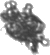

In [ ]:
# Display an example image 
Image.open(img_files['imgs/32738710.jpg'])

In [ ]:
# Load the image as a numpy array:
img = img_to_array(Image.open(img_files['imgs/32738710.jpg']))
img.shape

(55, 50, 1)

In [ ]:
max(img.reshape(-1))

255.0

In [ ]:
filePaths = []
for key in img_files:
    filePaths.append(key)
width = [] # list of width-size of all images
height = [] # list of height-size of all images
img_size = set() # list of pairs (width, height) of all images
for i in filePaths:
    im = Image.open(img_files[i])
    img_size.add(im.size)
    width_i, height_i = im.size
    width.append(width_i)
    height.append(height_i)
print("There are {} the sizes of images".format(len(img_size)))

There are 53074 the sizes of images


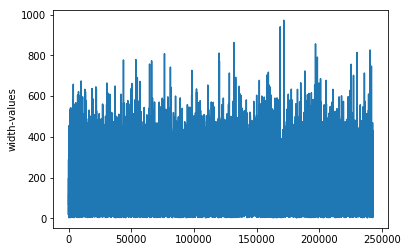

In [ ]:
# Draw width-values
plt.plot(width)
plt.ylabel('width-values')
plt.show()

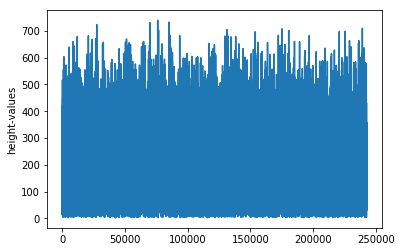

In [ ]:
# Draw height-values
plt.plot(height)
plt.ylabel('height-values')
plt.show()

In [ ]:
min(width), max(width)

(2, 972)

In [ ]:
min(height), max(height)

(2, 739)

In [ ]:
np.median(width), np.median(height)

(67.0, 87.0)

<div class="alert alert-info">
This Plankton dataset is gray-scale images with their size are various - up to 53,074 different sizes - ranging from 2 to  972 pixels wide and from 2 to 739 pixels height and in each pixel, the value ranges to 255. Hence, it is had to pre-process these images and scale them into the same size so that they can be processed by the CNN models. As you can see, the median of the width and height are 67 and  87 respectively. Therefore, we decided to resize and pad image to a square shape (64, 64). In addition, the gray-scale value in each pixel is converted from [0,255] into [0,1], in order to satisfy the requirement of the CNN model we used.
</div>

## Load Images and Create Labels for Plankton Dataset

In [ ]:
# Encode labels with value between 0 and n_classes-1
le = preprocessing.LabelEncoder()
le.fit(list(df['level2']))
labels = le.transform(list(df['level2']))
label_names = list(le.classes_)
df['class'] = list(labels)
df = df.loc[:, ['objid','class']]
export_csv = df.to_csv (r'export_dataframe.csv', index = None, header=True)

In [ ]:
# Re-check labels
df['class'].value_counts()

30    138439
32     26936
14     14014
34      9293
27      7848
37      5629
7       5141
22      5117
36      4044
33      3261
6       2888
17      2256
23      2227
20      2160
4       2105
26      1849
35      1821
5        845
29       751
24       710
31       685
12       670
10       549
11       525
0        481
19       367
21       357
8        334
18       257
16       191
3        186
28       145
15       131
1        117
9        100
13        68
38        61
25        37
2         12
Name: class, dtype: int64

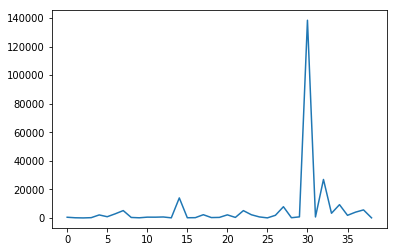

{30: 138439, 20: 2160, 37: 5629, 32: 26936, 5: 845, 1: 117, 6: 2888, 10: 549, 14: 14014, 7: 5141, 8: 334, 34: 9293, 17: 2256, 0: 481, 3: 186, 11: 525, 4: 2105, 22: 5117, 24: 710, 36: 4044, 12: 670, 23: 2227, 35: 1821, 18: 257, 33: 3261, 19: 367, 29: 751, 26: 1849, 16: 191, 15: 131, 28: 145, 9: 100, 27: 7848, 31: 685, 21: 357, 25: 37, 13: 68, 38: 61, 2: 12}
Shapes:
X:(242607, 64, 64, 1)
Y:(242607, 39)


In [ ]:
# Load train images id with class labels
filenames = [i for i in img_files if i.endswith('.jpg')]
with open('export_dataframe.csv', mode='r') as infile:
    reader = csv.reader(infile)
    file_to_class = {rows[0]:rows[1] for rows in reader}
# Calculate class counts
with open('export_dataframe.csv', mode='r') as infile:
    reader = csv.reader(infile)
    class_counts = {}
    for row in reader:
        if(row[1] != 'class'):
            class_counts[int(row[1])] = class_counts.get(int(row[1]), 0) + 1
    lists = sorted(class_counts.items())
    x, y = zip(*lists)
    plt.plot(x, y)
    plt.show()            
print(class_counts)       
X = np.empty([len(filenames),IMAGE_SIZE,IMAGE_SIZE,1])
Y_tmp = np.empty([len(filenames)])
Y = np.empty([len(filenames),N_CLASSES])
print('Shapes:\nX:{}\nY:{}'.format(X.shape, Y.shape))

<div class="alert alert-info">
    As we mentioned before, there is a strong class imbalance (lowest 12, highest 138439). The class with the highest samples is roughly higher 11537 times than the class with the lowest one. To counter this, oversampling minority classes to be as big as the majority classes can be one of the options used. To oversampling, we used RandomOverSampler from imblearn of scikit-learn, but this method really consumes RAM and Google Colab platform with 12G RAM cannot run. Therefore, we chose another method, this is class_weight of Keras to handle unbalanced classes. 
</div>

## Image Preprocessing
- <b>convert from [0,255] to [0.0 to 1.0]</b>
- <b>square and resize image to (64,64)</b>

In [ ]:
# Functions to Resize, Pad Image to Square Shape
def get_padding(i):
 
    if i%2 == 0:
        return (int(i/2),int(i/2))
    else:
        return (int(i/2-.5), int(i/2+.5))

def pad_image(img):
   
    H, W = img.shape
    if H == W:
        return img
    elif H > W:
        return np.pad(img, ((0,0), get_padding(H-W)), 'constant')
    else:
        return np.pad(img, (get_padding(W-H), (0,0)), 'constant')

def resize_image(img):
    
    return resize(img, (IMAGE_SIZE,IMAGE_SIZE), mode='reflect')

In [ ]:
for i in range(len(filenames)):
    # read and transform image to usable format
    img = np.array(Image.open(img_files[filenames[i]]))
    img = np.absolute(np.divide(img.astype(float), 255) - 1.0)
    img = resize_image(pad_image(img))
    # create a grayscale channel 
    img = img.reshape(IMAGE_SIZE,IMAGE_SIZE,1)
    
    X[i] = img
    Y_tmp[i]= int(file_to_class[filenames[i].split('/')[-1].split('.')[-2]])
    
print('Shapes:\nX:{}\nY:{}'.format(X.shape, Y_tmp.shape))
for i in range(len(Y_tmp)):
    Y[i][int(Y_tmp[i])] = 1.0
print('Shapes:\nX:{}\nY:{}'.format(X.shape, Y.shape))

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


Shapes:
X:(242607, 64, 64, 1)
Y:(242607,)
Shapes:
X:(242607, 64, 64, 1)
Y:(242607, 39)


### An example image after Preprocessing

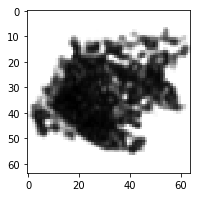

In [ ]:
f = plt.figure(figsize=(16,3))
sub1 = plt.subplot(1,4,1)
plt.imshow(X[250][:,:,0], cmap='binary')

## Split the Plankton dataset

In [ ]:
# The test dataset  accounts for 60%, validation 20% and testing 20%
X_train, X_val, X_test, y_train, y_val, y_test = X[:145565], X[145565:194086], X[194086:], Y[:145565], Y[145565:194086], Y[194086:]

## Estimate class weights for unbalanced datasets

In [ ]:
class_weight = class_weight.compute_class_weight('balanced', np.unique(Y_tmp[:169825]), Y_tmp[:169825])

In [ ]:
print(class_weight)

[1.25852231e+01 5.31035022e+01 4.83831909e+02 3.45594221e+01
 2.92443733e+00 7.49481442e+00 2.14084915e+00 1.21872017e+00
 1.92676424e+01 6.59770785e+01 1.14894121e+01 1.21633720e+01
 9.38467065e+00 9.46627648e+01 4.46889078e-01 4.58367072e+01
 3.11034799e+01 2.71985458e+00 2.50257884e+01 1.80684115e+01
 2.88185783e+00 1.67480276e+01 1.21565806e+00 2.78598028e+00
 8.39014871e+00 1.50154730e+02 3.34446020e+00 7.84027220e-01
 4.68224428e+01 8.23154476e+00 4.48846795e-02 8.77920802e+00
 2.31486214e-01 1.94050231e+00 6.76162606e-01 3.42333898e+00
 1.53165219e+00 1.10548037e+00 8.88670853e+01]


In [ ]:
# To free this memory again
del img_files
del(Y)
del(Y_tmp)

# DEFINE AND TRAIN CNN PRETRAINED NETWORK


<div class="alert alert-info">
<ul>
<li>As we mentioned at the beginning,  we use the technique fine-tuning a pre-trained network trained on ImageNet for applying deep learning to the smaller dataset - Plankton dataset to classifying plankton into 39  species. In this work, we use DenseNet with 121 layers architecture. </li>
    <li>We chose the <b>DenseNet</b> because it's the single best model compared to AlexNet, GoogleNet, InceptionV3, VGGNet, ResNet, SqueezeNet: it obtains the results in Plankton datasets, whom information derived from Alessandra Lumini and  Loris Nanni's experiment. (https://www.researchgate.net/publication/331324840_Deep_learning_and_transfer_learning_features_for_plankton_classification).</li>
<li>By observing, the first layers of deep networks often extract low-level features and the last layers often get high-level features bringing own characteristics of the dataset.</li>
<li>The original dataset (ImageNet dataset) contains 1.4 million labeled images and 1,000 different classes include invertebrate and fungus. Therefore, ImageNet may contain a few plankton images (We just guess, cannot find this information) and With our own dataset (Plankton dataset) just having around 250,000 images. That's why we add some more layers to before adding the last layer ( fully connected layer and softmax regression) having the number of units equaling the number of classes (with this Plankton dataset is 39).</li>
</ul>
</div>

## DenseNet

In [ ]:
# The DenseNet always only accept 3-channels color images, but our images are the single channel. The code below conversion to 3 channels is done inside the model.
# This not consume much RAM like the case if we use np.repeat to create images with 3-channels before we fed the data  to the model
# img_input = Input(shape=(64,64,1)) #we defined this variable at the beginning
# img_conc = Concatenate()([img_input, img_input, img_input]) #we defined this variable at the beginning
# Concatenate duplicates whole input, but puts it into channels, so from one channel it creates 3 channels

densenet_conv = DenseNet121(weights='imagenet', include_top=False,input_tensor=img_conc)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Model)          (None, 2, 2, 1024)        7037504   
_________________________________________________________________
flatten_1 (Flatten)          (None, 4096)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               1048832   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 39)                10023     
Total params: 8,096,359
Trainable params: 8,012,711
Non-trainable params: 83,648
_________________________________________________________________
Instructions

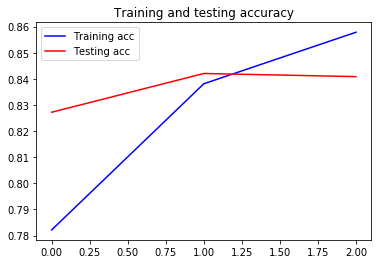

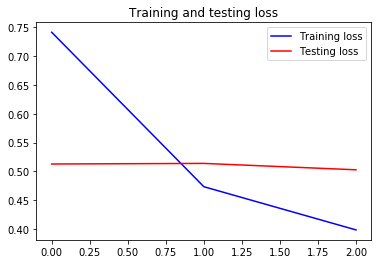

48521/48521 [==============================] - 19s 393us/step
test acc: 0.8408524144516668
test loss: 0.5040090836519922


In [ ]:
# Create the model
model = Sequential()
 
# Add the vgg convolutional base model
model.add(densenet_conv)

# Add new layers
model.add(Flatten())
model.add(Dense(256, activation='relu')) #we add dense layer so that the model can learn more complex functions and classify for better results.
model.add(Dropout(0.5)) #to avoid overfitting
model.add(Dense(N_CLASSES, activation='softmax')) #final layer with softmax activation
 
# Show a summary of the model. Check the number of trainable parameters
model.summary()

# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(lr=1e-4),
              metrics=['acc'])
# Train the model
start = time.time()
history = model.fit(X_train, y_train, batch_size = BATCH_SIZE2, validation_data = (X_val, y_val), epochs = N_EPOCHS, class_weight=class_weight, verbose = 1)
print("Training the Plankton dataset took {} seconds.".format(time.time() - start))
# Save the model
model.save('DenseNet121.h5')

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Testing acc')
plt.title('Training and testing accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Testing loss')
plt.title('Training and testing loss')
plt.legend()
 
plt.show()

# Evaluate on the test sets
test_loss, test_acc = model.evaluate(x = X_test, y = y_test, batch_size = BATCH_SIZE2)
print('test acc:', test_acc)
print('test loss:', test_loss)


In [ ]:
# Get the output of train_set
X_output = model.predict(X)
np.savetxt("drive/My Drive/EURECOM/Semester 2 - SPRING 2019/06 AML - Algorithmic Machine Learning/Lab03 - Plankton Challenge/flowcam/X_output.csv", X_output, delimiter=",")

In [ ]:
#  Classification Report
y_predicted = model.predict(X_test)
predicted  = y_predicted.argmax(axis = 1)
y_test = y_test.argmax(axis = 1)
report = classification_report(y_test, predicted)
print(report)

              precision    recall  f1-score   support

           0       0.84      0.58      0.69        84
           1       1.00      0.21      0.35        19
           2       0.00      0.00      0.00         2
           3       0.75      0.24      0.36        38
           4       0.83      0.74      0.78       391
           5       0.89      0.69      0.78       172
           6       0.96      0.89      0.92       580
           7       0.76      0.83      0.79      1061
           8       0.78      0.45      0.57        77
           9       1.00      0.13      0.23        23
          10       0.96      0.68      0.80       112
          11       0.71      0.21      0.32       116
          12       0.67      0.64      0.65       128
          13       0.00      0.00      0.00        12
          14       0.93      0.94      0.93      2827
          15       1.00      0.21      0.34        24
          16       0.40      0.27      0.32        30
          17       0.80    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [ ]:
np.savetxt("drive/My Drive/EURECOM/Semester 2 - SPRING 2019/06 AML - Algorithmic Machine Learning/Lab03 - Plankton Challenge/flowcam/prediction.csv", y_predicted, delimiter=",")

In [ ]:
#  Randomly pick indice of 10 images from test sets to perform
idx = np.random.randint(0, X_test.shape[0], 10)

In [ ]:
# Predict class of these 10 images
Y_test_pred = model.predict(X_test[idx])
preds = Y_test_pred.argmax(axis = 1)
preds

array([36, 34, 30,  6, 30, 30, 30, 30, 14, 30])

In [ ]:
# Get true class of these 10 images
true = y_test[idx]
true

array([36, 34, 30,  6, 30, 30, 30, 32, 14, 30])

True class: detritus
Predicted class: detritus


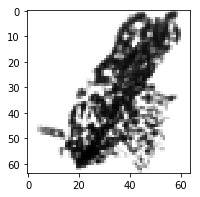

In [ ]:
 # Display an image classified wrongly
f = plt.figure(figsize=(16,3))
sub1 = plt.subplot(1,4,1)
plt.imshow(X_test[idx[5]][:,:,0], cmap='binary')
print("True class: {}".format(label_names[true[5]]))
print("Predicted class: {}".format(label_names[preds[5]]))

True class: nauplii (Crustacea)
Predicted class: nauplii (Crustacea)


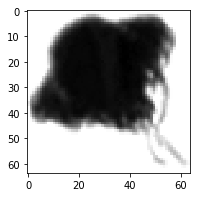

In [ ]:
 # Display an image classified right
f = plt.figure(figsize=(16,3))
sub1 = plt.subplot(1,4,1)
plt.imshow(X_test[idx[1]][:,:,0], cmap='binary')
print("True class: {}".format(label_names[true[1]]))
print("Predicted class: {}".format(label_names[preds[1]]))

## RESULTS on DEEP-LEARNING

<div class="alert alert-info">
The training procedures are performed setting the number of epochs for training of 3 and using a batch size with 256 observations at each iteration and fixing the learning rate to 0.001. <p>

With this dataset, the batch size of 256 is the best fit because if we choose the batch size smaller like 128 or 64 or even smaller, the sessions were crashed due to the RAM size of only 12G.  In general, Larger batch sizes result in faster progress in training, but don't always converge as fast. Smaller batch sizes train slower but can converge faster. That's why we did not choose the batch size larger like 512. <p>

In general, the models improve with more epochs of training, to a point. We conducted an experiment and saw that this point was 3. <p>

We know that if the learning rate is too large, the model can hardly reach the minimum value. But if it is too small, the model can be stuck in a local minimum fast and cannot find out desirable point anymore. We tried the experience and 0.001 was the most suitable. <p>
</div>

<div class="alert alert-info">
Our model gets f1-score 0.54 for test set. As you see cells above, f1-score for some classes is not high even 0.00  because of the number of their samples not much, for instance, 'tempChaetoceros danicus': 0.00, 'Cyttarocylis': 0.16, 'Xystonellidae'': 0.00
</div>

# Features engineering with XGBOOST

<div class="alert alert-info">
We assume that the file <b>features_native.csv</b>, which contained the morphological handcrafted features computed by ZooProcess. The <b>handcrafted features</b> in this case will be considered as they were extracted by experts with their specific domain knowledge and would be more sophisticated and if we could use it that would help to improve the accuracy of our model. <p>

The experiment will have two parts: <p>
- <b>XGBOOST</b> on those <b>handcrafted</b> features only and compared with the Deep Learning outcome. <p> 
- Second, We consider it will be an <b>ensemble learning</b> experiment whenever we will use the outcomes from Deep-Learning on image only, putted together with the <b>handcrafted</b> features as a input on <b>XGBOOST</b> model in order to archive a better outcome. <p>
</div>

In [1]:
import pandas as pd
import numpy as np

#from scipy.stats import uniform, randint
import scipy.stats as stats

import xgboost as xgb
from xgboost import XGBClassifier
from sklearn import preprocessing

from sklearn.metrics import f1_score
#from sklearn.cross_validation import KFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
%matplotlib inline
plt.style.use(style='ggplot')
plt.rcParams['figure.figsize'] = (10, 6)

In [2]:
# Get the data 
url_meta = 'https://bitbucket.org/longng/plankton-image-classification/downloads/meta.csv'
url_features = 'https://bitbucket.org/longng/plankton-image-classification/downloads/features_native.csv'   
url_DLoutput = 'https://bitbucket.org/longng/plankton-image-classification/downloads/X_output.csv'
url_classref = 'https://bitbucket.org/longng/plankton-image-classification/downloads/export_dataframe.csv'

In [3]:
df = pd.read_csv(url_features) #hand crafted features
# dftemp = pd.read_csv(url_meta)
dfDLoutput = pd.read_csv(url_DLoutput, header=None) #result from Deep Learning Model
dfclassre = pd.read_csv(url_classref) #encoded classes with objid
df.shape, dfDLoutput.shape, dfclassre.shape

((243610, 65), (242607, 39), (242607, 2))

In [4]:
df.head()

,objid,area,meanimagegrey,mean,stddev,min,perim.,width,height,major,...,symetriev_area,nb1_area,nb2_area,nb3_area,nb1_range,nb2_range,nb3_range,median_mean,median_mean_range,skeleton_area
0,32756761.0,6653.0,167.18,205.76,65.341,85,779.66,109,123,147.8,...,0.005988,0.017964,0.017964,0.059880,0.017647,0.017647,0.058824,47,0.276471,91.778443
1,32759364.0,1275.0,165.83,234.29,38.562,98,186.99,33,65,82.4,...,0.012048,0.024096,0.012048,0.006024,0.025478,0.012739,0.006369,21,0.133758,18.030120
2,32758055.0,2416.0,167.92,239.15,25.590,94,276.33,26,115,138.8,...,0.017857,0.011905,0.053571,0.107143,0.012422,0.055901,0.111801,16,0.099379,24.892857
3,32758988.0,1433.0,167.34,248.79,20.933,107,388.40,126,117,151.2,...,0.005988,0.000000,0.000000,0.023952,0.000000,0.000000,0.027027,6,0.040541,99.365269
4,32760598.0,1650.0,166.89,250.42,14.603,124,751.96,66,239,278.7,...,0.017964,0.029940,0.083832,0.059880,0.038168,0.106870,0.076336,5,0.038168,109.449102


In [5]:
#output result from Deep Learning Model
dfDLoutput.head()

,0,1,2,3,4,5,6,7,8,9,...,29,30,31,32,33,34,35,36,37,38
0,4.225924e-04,5.353846e-06,4.398931e-07,1.035600e-04,3.435937e-04,2.287104e-03,4.355395e-04,3.163126e-02,1.493929e-04,2.174154e-04,...,1.646541e-04,0.216345,2.472599e-04,1.547790e-01,3.606438e-03,5.748483e-01,3.317691e-03,5.535810e-04,2.047741e-04,8.097545e-06
1,2.933678e-35,0.000000e+00,0.000000e+00,0.000000e+00,3.850884e-34,1.714461e-34,3.218765e-32,5.307083e-34,3.143089e-38,0.000000e+00,...,1.781475e-31,1.000000,1.780250e-33,6.749417e-19,4.423834e-23,1.112021e-28,2.745476e-34,8.658356e-35,1.956806e-31,0.000000e+00
2,9.539363e-11,4.330447e-13,1.361406e-15,5.001490e-11,1.131744e-09,2.093540e-10,2.082494e-08,1.231566e-08,4.706450e-10,1.471578e-12,...,4.195325e-09,0.012949,2.484652e-09,9.870500e-01,3.086805e-07,1.009055e-07,4.239455e-09,3.761698e-09,6.762800e-10,7.223624e-14
3,2.947655e-07,2.374578e-07,7.156666e-09,4.608875e-07,1.083095e-05,2.702946e-06,1.076727e-06,1.973584e-06,1.790007e-06,8.922850e-08,...,1.866016e-04,0.770909,5.435576e-07,2.681114e-04,1.553559e-04,1.690853e-05,1.114455e-06,1.539732e-05,9.388768e-04,7.061394e-07
4,2.350423e-09,7.563250e-12,8.066360e-16,1.054747e-09,2.419430e-09,8.104064e-09,3.573103e-08,1.551049e-08,3.144595e-10,2.239782e-11,...,4.379985e-09,0.752444,4.454556e-09,2.475488e-01,4.824296e-06,1.434474e-06,2.798373e-08,9.952091e-10,4.994712e-09,1.141087e-12


In [6]:
dfclassre.columns = ['objidtemp', 'class']
dftemp = pd.concat([dfclassre,dfDLoutput], axis=1)
dftemp.head()

,objidtemp,class,0,1,2,3,4,5,6,7,...,29,30,31,32,33,34,35,36,37,38
0,32756761,30,4.225924e-04,5.353846e-06,4.398931e-07,1.035600e-04,3.435937e-04,2.287104e-03,4.355395e-04,3.163126e-02,...,1.646541e-04,0.216345,2.472599e-04,1.547790e-01,3.606438e-03,5.748483e-01,3.317691e-03,5.535810e-04,2.047741e-04,8.097545e-06
1,32759364,30,2.933678e-35,0.000000e+00,0.000000e+00,0.000000e+00,3.850884e-34,1.714461e-34,3.218765e-32,5.307083e-34,...,1.781475e-31,1.000000,1.780250e-33,6.749417e-19,4.423834e-23,1.112021e-28,2.745476e-34,8.658356e-35,1.956806e-31,0.000000e+00
2,32758055,20,9.539363e-11,4.330447e-13,1.361406e-15,5.001490e-11,1.131744e-09,2.093540e-10,2.082494e-08,1.231566e-08,...,4.195325e-09,0.012949,2.484652e-09,9.870500e-01,3.086805e-07,1.009055e-07,4.239455e-09,3.761698e-09,6.762800e-10,7.223624e-14
3,32758988,37,2.947655e-07,2.374578e-07,7.156666e-09,4.608875e-07,1.083095e-05,2.702946e-06,1.076727e-06,1.973584e-06,...,1.866016e-04,0.770909,5.435576e-07,2.681114e-04,1.553559e-04,1.690853e-05,1.114455e-06,1.539732e-05,9.388768e-04,7.061394e-07
4,32760598,37,2.350423e-09,7.563250e-12,8.066360e-16,1.054747e-09,2.419430e-09,8.104064e-09,3.573103e-08,1.551049e-08,...,4.379985e-09,0.752444,4.454556e-09,2.475488e-01,4.824296e-06,1.434474e-06,2.798373e-08,9.952091e-10,4.994712e-09,1.141087e-12


In [7]:
dftemp.shape

(242607, 41)

In [8]:
import missingno as msno # Missingno package for visualizing missing data

<div class="alert alert-info">
Although XGBOOST can accept the missing values, but will still want to have a quick look on it and impute by median
</div>

In [9]:
total = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum()/df.isnull().count()*100).sort_values(ascending=False)
missing = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing = missing[missing['Total']>0]
print("The below table of the attributes having missing values and percentages of non-missing values of these attributes:")
print()
print(missing)
print()
print("The number of attributes have missing values are", len(missing))

The below table of the attributes having missing values and percentages of non-missing values of these attributes:

                Total    Percent
perimareaexc    34428  14.132425
feretareaexc    34428  14.132425
cdexc           34428  14.132425
skeleton_area    6854   2.813513
nb1_area         6854   2.813513
symetrieh_area   6854   2.813513
symetriev_area   6854   2.813513
convarea_area    6854   2.813513
nb2_area         6854   2.813513
nb3_area         6854   2.813513

The number of attributes have missing values are 10


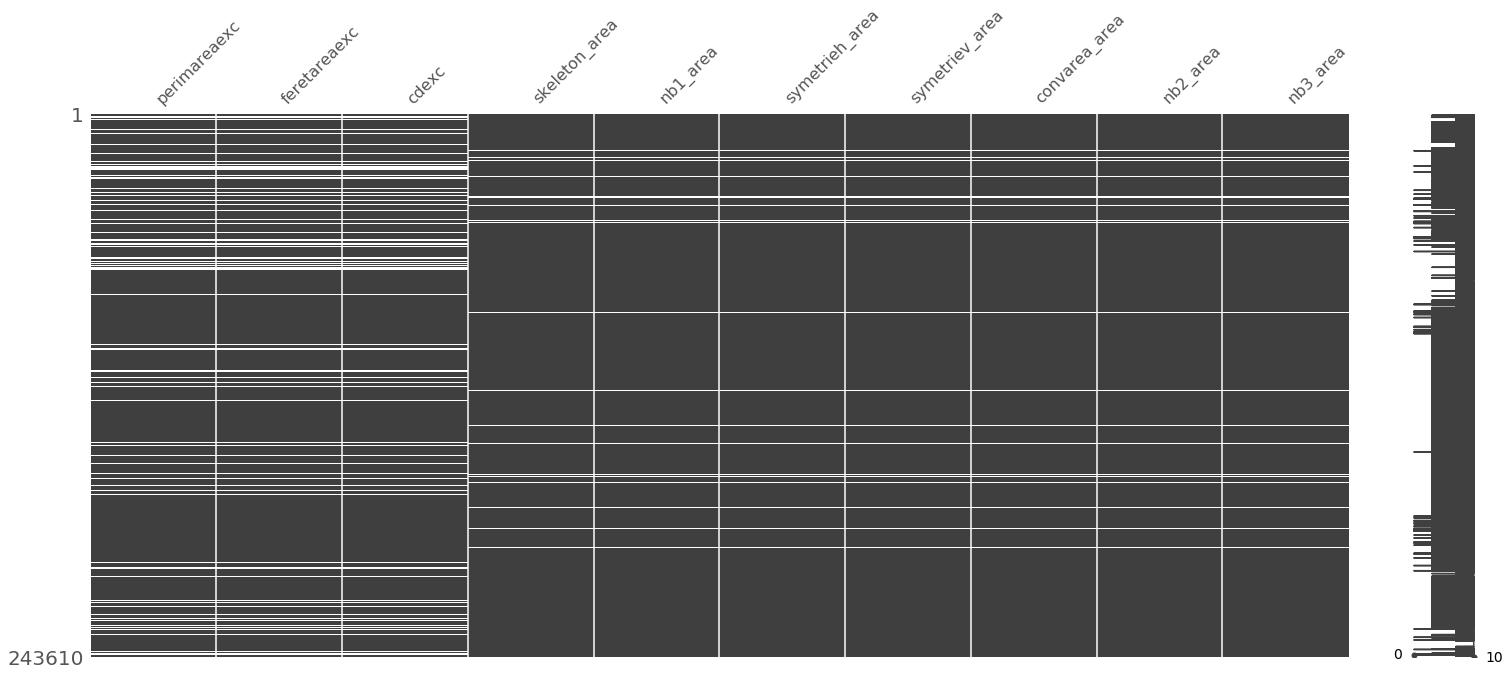

In [10]:
#collisions = df.nyc_collision_factors()
#collisions = collisions.replace("nan", np.nan)
%matplotlib inline
msno.matrix(df[missing.index])

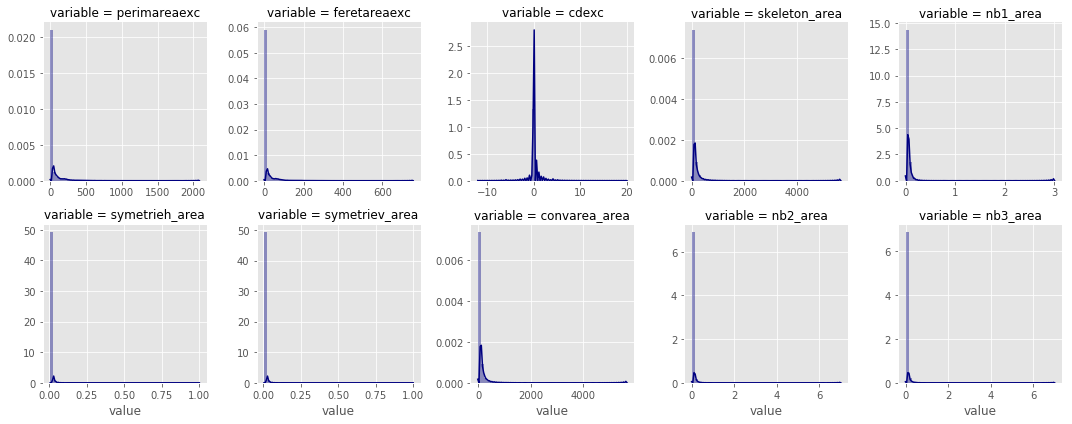

CPU times: user 6.42 s, sys: 2.06 s, total: 8.48 s
Wall time: 6.12 s


In [11]:
%%time
# visualize the distribution of each numerical feature
#missing = missing[:]
temp = pd.melt(df, value_vars=missing.index)
grid = sns.FacetGrid(temp, col="variable",  col_wrap=5 , height=3.0, 
                     aspect=1.0,sharex=False, sharey=False)
sns.set_palette('Paired',30)
grid.map(sns.distplot, "value",color='navy')
plt.show()

In [12]:
#Fill missing data with median values as their all heavily skew
for col in missing.index:
  fillupvalue = df[col].dropna().median()
  df.loc[df[col].isnull(),col] = fillupvalue


In [13]:
# Check if there are any missing values left
all_data_na = (df.isnull().sum() / len(df)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
print(missing_data.head())

Empty DataFrame
Columns: [Missing Ratio]
Index: []


## XGBOOST on those handcrafted features only

In [14]:
# merge the objid and classification
df = pd.merge(df, dfclassre, left_on='objid', right_on='objidtemp', how='left').drop(['objidtemp'], axis=1)
df.shape

(243610, 66)

In [15]:
display(df.info())
display(df.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243610 entries, 0 to 243609
Data columns (total 66 columns):
objid                243610 non-null float64
area                 243610 non-null float64
meanimagegrey        243610 non-null float64
mean                 243610 non-null float64
stddev               243610 non-null float64
min                  243610 non-null int64
perim.               243610 non-null float64
width                243610 non-null int64
height               243610 non-null int64
major                243610 non-null float64
minor                243610 non-null float64
angle                243610 non-null int64
circ.                243610 non-null float64
feret                243610 non-null float64
intden               243610 non-null float64
median               243610 non-null int64
skew                 243610 non-null float64
kurt                 243610 non-null float64
%area                243610 non-null float64
area_exc             243610 non-null float64

None

,objid,area,meanimagegrey,mean,stddev,min,perim.,width,height,major,...,nb1_area,nb2_area,nb3_area,nb1_range,nb2_range,nb3_range,median_mean,median_mean_range,skeleton_area,class
0,32756761.0,6653.0,167.18,205.76,65.341,85,779.66,109,123,147.8,...,0.017964,0.017964,0.059880,0.017647,0.017647,0.058824,47,0.276471,91.778443,30.0
1,32759364.0,1275.0,165.83,234.29,38.562,98,186.99,33,65,82.4,...,0.024096,0.012048,0.006024,0.025478,0.012739,0.006369,21,0.133758,18.030120,30.0
2,32758055.0,2416.0,167.92,239.15,25.590,94,276.33,26,115,138.8,...,0.011905,0.053571,0.107143,0.012422,0.055901,0.111801,16,0.099379,24.892857,20.0
3,32758988.0,1433.0,167.34,248.79,20.933,107,388.40,126,117,151.2,...,0.000000,0.000000,0.023952,0.000000,0.000000,0.027027,6,0.040541,99.365269,37.0
4,32760598.0,1650.0,166.89,250.42,14.603,124,751.96,66,239,278.7,...,0.029940,0.083832,0.059880,0.038168,0.106870,0.076336,5,0.038168,109.449102,37.0


In [16]:
# Check if there are any missing values
total = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum()/df.isnull().count()*100).sort_values(ascending=False)
missing = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing = missing[missing['Total']>0]
print("The below table of the attributes having missing values and percentages of non-missing values of these attributes:")
print()
print(missing)
print()
print("The number of attributes have missing values are", len(missing))

The below table of the attributes having missing values and percentages of non-missing values of these attributes:

       Total   Percent
class   1003  0.411724

The number of attributes have missing values are 1


In [17]:
# delete the missing values
df = df.dropna()

In [18]:
# Check if there are any missing values left
all_data_na = (df.isnull().sum() / len(df)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
print(missing_data.head())

Empty DataFrame
Columns: [Missing Ratio]
Index: []


In [19]:
df.shape

(242607, 66)

In [20]:
#get number of classes
n_class = df['class'].nunique()
n_class

39

In [21]:
X_train = df.drop(['objid','class'], axis=1)[:194086]
X_test = df.drop(['objid','class'], axis=1)[194086:]

y_train = df['class'][:194086]
y_test = df['class'][194086:]
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((194086, 64), (48521, 64), (194086,), (48521,))

## Trainng and fitting handrafted features with XGBOOST

In [ ]:
%%time
#Early test with parameters
model1 = XGBClassifier(learning_rate =0.1, 
                     n_estimators=100, #by default = 100
                     max_depth=5, 
                     min_child_weight=1, 
                     gamma=0,
                     subsample=0.8,
                     colsample_bytree=0.8,
                     objective= 'multi:softprob',
                     num_class= n_class,
                     nthread=4,
                     seed=27,
                     eval_metric="auc")

model1.fit(X_train, y_train)#, early_stopping_rounds=5, eval_set=[(X_test, y_test)])

CPU times: user 1h 17min 18s, sys: 24.9 s, total: 1h 17min 43s
Wall time: 19min 59s


In [ ]:
%%time
#scoring on train set
y_pred = model1.predict(X_train) #export class
predictions = [round(value) for value in y_pred]
print(f1_score(y_train, predictions, average='macro')) 
print(f1_score(y_train, predictions, average='weighted')) 

0.628719164694144
0.8365597668196432
CPU times: user 2min 7s, sys: 524 ms, total: 2min 7s
Wall time: 33.3 s


In [ ]:
%%time
# scoring on test set
y_pred = model1.predict(X_test) #export class
predictions = [round(value) for value in y_pred]
print(f1_score(y_test, predictions, average='macro')) 
print(f1_score(y_test, predictions, average='weighted')) 

0.38613666406154085
0.6960725458965256
CPU times: user 31.7 s, sys: 32 ms, total: 31.8 s
Wall time: 8.23 s


In [ ]:
#experiment with GridSearchCV
param_test1 = {
                'max_depth':range(6,8,2),
                'min_child_weight':range(1,3,2)
                }

model2 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, 
                                                n_estimators=500, 
                                                max_depth=5,
                                                min_child_weight=1,
                                                gamma=0, 
                                                subsample=0.8, 
                                                colsample_bytree=0.8,
                                                objective= 'multi:softprob',
                                                num_class= n_class,
                                                nthread=4, 
                                                seed=27), 
                        param_grid = param_test1, 
                        scoring='f1_macro'
                        #n_jobs=1
                     )

model2.fit(X_train, y_train)

In [28]:
model2.cv_results_

{'mean_fit_time': array([7845.08404493]),
 'mean_score_time': array([133.84889396]),
 'mean_test_score': array([0.40925932]),
 'mean_train_score': array([0.99518005]),
 'param_max_depth': masked_array(data=[6],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_min_child_weight': masked_array(data=[1],
              mask=[False],
        fill_value='?',
             dtype=object),
 'params': [{'max_depth': 6, 'min_child_weight': 1}],
 'rank_test_score': array([1], dtype=int32),
 'split0_test_score': array([0.40613364]),
 'split0_train_score': array([0.99691625]),
 'split1_test_score': array([0.37470671]),
 'split1_train_score': array([0.9958181]),
 'split2_test_score': array([0.44694489]),
 'split2_train_score': array([0.99280579]),
 'std_fit_time': array([423.3867381]),
 'std_score_time': array([8.03003424]),
 'std_test_score': array([0.02957207]),
 'std_train_score': array([0.00173768])}

In [50]:
print("Best score:", model2.best_score_) 
print("Best parameters:", model2.best_params_) 
print("Best best_estimator_:", model2.best_estimator_) 
print("Scorer:", model2.scorer_) 
print("Numer of time (hours) to retrain the best score:", model2.refit_time_/60/60) 

Best score: 0.40925932070267934
Best parameters: {'max_depth': 6, 'min_child_weight': 1}
Best best_estimator_: XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=6, min_child_weight=1, missing=None, n_estimators=500,
       n_jobs=1, nthread=4, num_class=39, objective='multi:softprob',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=27, silent=True, subsample=0.8)
Scorer: make_scorer(f1_score, pos_label=None, average=macro)
Numer of time (hours) to retrain the best score: 3.799543668760194


**Compared with the previous result, we can concluded that the best parameters now is:** ``{'max_depth': 5, 'min_child_weight': 1}`` as the result from GridSearchCV actually worse that the previous one. 

In [ ]:
%%time
#Tune other parameter: gamma
param_test2 = { 
    'gamma':[i/10.0 for i in range(1,3)] 
}
model3 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, 
                                                n_estimators=500, 
                                                max_depth=5,
                                                min_child_weight=1,
                                                subsample=0.8, 
                                                colsample_bytree=0.8,
                                                objective= 'multi:softprob',
                                                num_class= n_class,
                                                nthread=4, 
                                                seed=27), 
                        param_grid = param_test2, 
                        scoring='f1_macro'
                        #n_jobs=1
                     )
model3.fit(X_train, y_train)

/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:113

In [ ]:
model3.cv_results_

In [ ]:
print("Best score:", model3.best_score_) 
print("Best parameters:", model3.best_params_) 
print("Best best_estimator_:", model3.best_estimator_) 
print("Scorer:", model3.scorer_) 
print("Numer of time (hours) to retrain the best score:", model3.refit_time_/60/60) 

# Conclusion

<div class="alert alert-info">
<ul>
    <li>We have successfully implemented the DenseNet - Deep Learning Model on our Dataset achieved <b>f1_score macro at 54&#37 </b> </li> 
    <li>We have tried to implement the <b>handcrafted features</b> from <b>features_native.csv</b> on <b>XGBOOST</b> model but did not beat the score from Deep Learning. However, due to the limited resource from Zoe (only 6 hours per session) or Google Colab - pretty slow and limited in 12 hours, we could not do more parameter tunning via <b>GridSearchCV</b> function from Scikit-learn library. We expect the result could be better if we could have more resources </li>
    <li>We also do not have enough time and resoruces on the experiment with ensemble learning when we expect to use the 39 features export from Deep Learning Models, then put together with the <b>handcrafted features</b> as input of <b>XGBOOST</b> model<tt></li> 
</ul>
</div>